# Task 02: Stock price prediction using LSTM
This task involves analysing stock prices for a company (in this case [microsoft](https://www.microsoft.com/en-us/)) and predict upcoming stock prices...

# Data analysis:

The dataset was downloaded from [Kaggle](https://www.kaggle.com/datasets/mayankanand2701/microsoft-stock-price-dataset).

## Dataset structure:
- **Date**: The date.
- **Open**: The opening price of the stock.
- **High**: The high price of that day.
- **Low**: The low price of that day.
- **Close**: The closed price of that day.
- **Volume**: The amount of stocks traded during that day.
- **Adj\[usted] Close**: The stock's closing price that has been amended to include any distributions/corporate actions that occurs before next days open.


## Loading data:

In [1]:
!ls
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# since we already know that there is a column containing a date, we can directly convert it to datetime
df = pd.read_csv("./Dataset/Microsoft Dataset.csv", parse_dates=["Date"]) # the name was not changed so that once the data is downloaded from its source it comes in the exact file name
df.head()

Dataset  Stock_price_prediction.ipynb  Untitled.ipynb


,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400


In [2]:
df.sort_values("Date")

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060591,47894400
...,...,...,...,...,...,...,...
9627,2024-05-24,427.190002,431.059998,424.410004,430.160004,430.160004,11845800
9628,2024-05-28,429.630005,430.820007,426.600006,430.320007,430.320007,15718000
9629,2024-05-29,425.690002,430.940002,425.690002,429.170013,429.170013,15517100
9630,2024-05-30,424.299988,424.299988,414.239990,414.670013,414.670013,28394500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9632 entries, 0 to 9631
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       9632 non-null   datetime64[ns]
 1   Open       9632 non-null   float64       
 2   High       9632 non-null   float64       
 3   Low        9632 non-null   float64       
 4   Close      9632 non-null   float64       
 5   Adj Close  9632 non-null   float64       
 6   Volume     9632 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 526.9 KB


In [4]:
# cut a sample duration for more recent years 
df = df[df["Date"].dt.year>=2020]

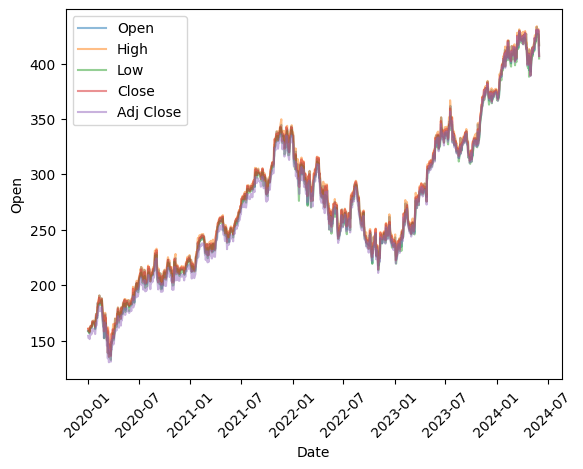

In [5]:
sns.lineplot(data=df, x="Date", y="Open", alpha=.5, label="Open")
sns.lineplot(data=df, x="Date", y="High", alpha=.5, label="High")
sns.lineplot(data=df, x="Date", y="Low", alpha=.5, label="Low")
sns.lineplot(data=df, x="Date", y="Close", alpha=.5, label="Close")
sns.lineplot(data=df, x="Date", y="Adj Close", alpha=.5, label="Adj Close")
plt.legend()
plt.xticks(rotation=45)
plt.show()

One simple remark is that all the prices are very close to each other, so in this study, we will focus only on `"close"` value since it represents the price at the end of the day.

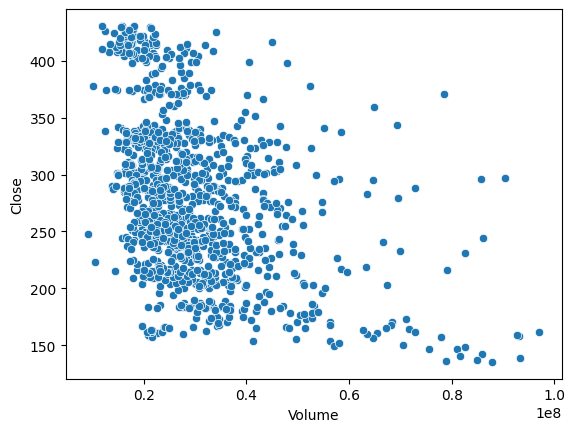

In [6]:
# checking influence of volume on close price
sns.scatterplot(data=df, x="Volume", y="Close")
plt.show()

The volume of transactions is mostly high when stock close price is too high, which reflects the behavior of investors in these regards (low shares of stocks when they are expensive).

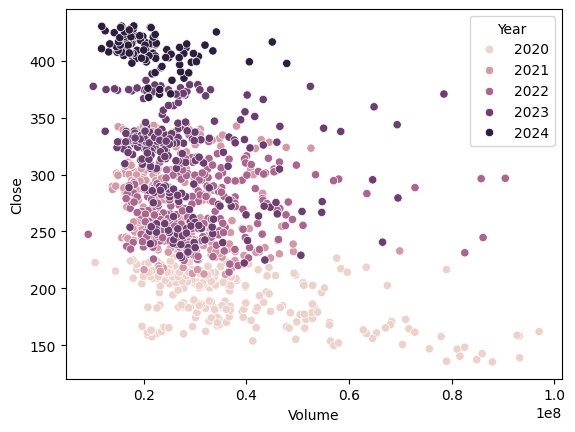

In [7]:
# visualising the trends based on trading year
df["Year"] = df["Date"].dt.year

sns.scatterplot(data=df, x="Volume", y="Close", hue="Year")
plt.show()

This visualisation shows an interesting remark, the number of transactions got on a specific range apx: \[0.0, 2e8], which tells that the volume of trades lost its influence on the price (or the influence got inverted with the high stock price in recent years).
in this case, probably the stock prices change with no other factor influencing it.

In [8]:
corr_tbl = df.corr()
corr_tbl.style.background_gradient(cmap='coolwarm')

,Date,Open,High,Low,Close,Adj Close,Volume,Year
Date,1.000000,0.844991,0.847390,0.844122,0.845374,0.856790,-0.342569,0.974815
Open,0.844991,1.000000,0.999341,0.999266,0.998328,0.998067,-0.402131,0.822224
High,0.847390,0.999341,1.000000,0.999140,0.999191,0.998992,-0.390713,0.824972
Low,0.844122,0.999266,0.999140,1.000000,0.999299,0.998976,-0.415879,0.820786
Close,0.845374,0.998328,0.999191,0.999299,1.000000,0.999691,-0.404912,0.822412
Adj Close,0.856790,0.998067,0.998992,0.998976,0.999691,1.000000,-0.403075,0.834214
Volume,-0.342569,-0.402131,-0.390713,-0.415879,-0.404912,-0.403075,1.000000,-0.292405
Year,0.974815,0.822224,0.824972,0.820786,0.822412,0.834214,-0.292405,1.000000


This visualisation reveals that there is a weak correlation between volume and stock close price, but the date and the year has an even stronger one (the strongest).
so we can only treat stock (close) prices with no intervention of other factors.

In [9]:
# analysing sequence influence
df = df[["Date", "Close"]]
def create_sequences(df: pd.DataFrame, n: int, colname: str, no_nan:bool=False):
    ret = df
    colnames = [colname]
    if n <= 1:
        raise ValueError("enter only values greater than 1")
    ret[colname+"_1"] = ret[colname].shift(1)
    colnames.append(colname+"_1")
    for i in range(1, n-1):
        ret[colname+"_"+str(i+1)] = ret[colname+"_"+str(i)].shift(1)
        colnames.append(colname+"_"+str(i+1))
    return (ret.iloc[n-1:] if no_nan else ret), colnames



# Predictions:
In the prediction section, we will use **LSTM (Long short term memory) models**, which are Recurrent neural networks that can generate results based on the input data and past results (which are saved in a "memory").

In [10]:
# importing libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError, RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler

# Preparing data
per = .8
test_per = .1
sequence_length = 5

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df["Close"].values.reshape(-1, 1))

df["Close_scaled"] = scaler.transform(df[["Close"]])
vals, closes = create_sequences(df, sequence_length, "Close_scaled", True)
#vals, closes = create_sequences(df, sequence_length, "Close", True)
s1 = int(vals.shape[0] * per)
s2 = int(vals.shape[0] * per) + int(vals.shape[0] * test_per)

dates = vals["Date"]
d_train = dates.iloc[:s1].values
d_val = dates.iloc[s1:s2].values
d_test = dates.iloc[s2:].values
vals = vals.drop(["Date", "Close"], axis=1)

X = vals.drop("Close_scaled", axis=1)
y = vals["Close_scaled"]

X_train = X[:s1].values
X_test = X[s2:].values
y_train = y[:s1].values
y_test = y[s2:].values
X_val = X[s1:s2].values
y_val = y[s1:s2].values

X_train = np.reshape(X_train, (X_train.shape[0], -1, 1))
y_train = np.reshape(y_train, (y_train.shape[0], -1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], -1, 1))
y_test = np.reshape(y_test, (y_test.shape[0], -1, 1))
X_val = np.reshape(X_val, (X_val.shape[0], -1, 1))
y_val = np.reshape(y_val, (y_val.shape[0], -1, 1))

# convert dates into numbers
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape, d_train.shape, d_test.shape, d_val.shape

2024-07-20 16:04:43.204959: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-20 16:04:43.235057: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-20 16:04:43.324208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 16:04:43.483185: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 16:04:43.528602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-20 16:04:43.637801: I tensorflow/core/platform/cpu_feature_gu

((885, 4, 1),
 (885, 1, 1),
 (112, 4, 1),
 (112, 1, 1),
 (110, 4, 1),
 (110, 1, 1),
 (885,),
 (112,),
 (110,))

In [11]:
# initialising neural network
nn = Sequential()

exp = 2
layer_length = 60

# adding LSTM and Dropout layers
for _ in range(exp):
  nn.add(LSTM(layer_length, return_sequences=True))
  nn.add(Dropout(.2))

nn.add(LSTM(layer_length))
nn.add(Dropout(.2))
nn.add(Dense(1, activation="linear"))

nn.compile(optimizer='adam'
, loss='mean_squared_error'
, metrics=[MeanAbsoluteError(), MeanSquaredError(), MeanAbsolutePercentageError(), RootMeanSquaredError()])

In [12]:
# Setting up early stopping
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=10,           # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)
# Train the model
nn.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 37s 218ms/step - loss: 0.1017 - mean_absolute_error: 0.2706 - mean_absolute_percentage_error: 164845.8750 - mean_squared_error: 0.1017 - root_mean_squared_error: 0.3130 - val_loss: 0.0495 - val_mean_absolute_error: 0.2177 - val_mean_absolute_percentage_error: 30.8266 - val_mean_squared_error: 0.0495 - val_root_mean_squared_error: 0.2224
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0118 - mean_absolute_error: 0.0887 - mean_absolute_percentage_error: 330102.2812 - mean_squared_error: 0.0118 - root_mean_squared_error: 0.1081 - val_loss: 0.0134 - val_mean_absolute_error: 0.1127 - val_mean_absolute_percentage_error: 15.9346 - val_mean_squared_error: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0037 - mean_absolute_error: 0.0492 - mean_absolute_percentage_error: 213846.0000 - mean_squared_error: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 8.0782e-04 - val_mean_absolu

28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


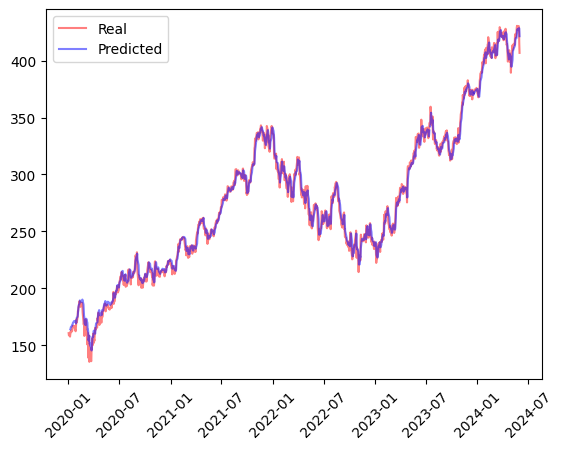

In [13]:
# prediction
y_pred = scaler.inverse_transform(nn.predict(X_train)).flatten()
y_val_pred = scaler.inverse_transform(nn.predict(X_val)).flatten()
y_test_pred = scaler.inverse_transform(nn.predict(X_test)).flatten()

plt.plot(df["Date"], df["Close"], label="Real", c="red", alpha=.5)

plt.plot(d_train, y_pred,  label="Predicted", c="blue", alpha=.5)
plt.plot(d_test, y_test_pred, c="blue", alpha=.5)
plt.plot(d_val, y_val_pred, c="blue", alpha=.5)

plt.legend()
plt.xticks(rotation=45)
plt.show()